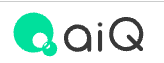

[disclaimer](../../disclaimer.txt/)

# aiQ DataHub: aiQ POS Csmr Goods Evaluation Notebook
- aiQ POS Csmr Goods はスーパーマーケット、ドラッグストアやコンピニなどの小売店舗で販売された商品の売上データを TICKER ごとにまとめたものです
- 処方箋医薬品、バーコードの無い生鮮食品などは商品カバレッジに含まれません

In [1]:
# 自作モジュールを自動更新を行うためのコマンド
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import sys
import numpy as np
import pandas as pd
import plotly.io
from aiq_strategy_robot.data.data_accessor import DAL

verbose = False
for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

if '../..' not in sys.path:
    sys.path.append('../..')

from utils.shortcut import goods_dataset as sc

- standard data handler のインスタンスを作成する
- data handler はデータ取得やデータ加工のライブラリを保持するオブジェクト

In [3]:
sdh = DAL()

## Step2: Load Data to `sdh`
ここではデータ分析のデモが主眼であるため、個別に用意しておいた簡易ローダーを経由してデータを読み込むこととする

### データロード
当該サンプルではデータファイルのサンプルを使用して以降の説明を行います.<br>
実際のデータロードを行いながらサンプルを実行したい場合、`load_sample_dataset`メソッドの`data_dir`を指定せずに実行してください.

```
# データソースからロード
sc.load_sample_dataset(sdh, start_date='2015-09-30', end_date='2024-06-01')
```

なお、データファイル（サンプルデフォルト）のデータソースは<br>

    - market:      factset
    - fundamental: factset
    - alternative: aiQ csmr Goods

データローダーによるデータソースは<br>

    - market:      finnhub
    - fundamental: finnhub
    - alternative: aiQ csmr Goods

となります.


In [4]:
# ファイルデータから data handler (`sdh`) に登録
sc.load_sample_dataset(sdh, data_dir=sc.DEFAULT_DIR)

# 登録された data_id を確認する
display(sdh.extract_definition)

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,external,sample,Unknown,aiq_pos_csmr_goods,"[1301-JP, 1332-JP, 1333-JP, 1334-JP, 1352-JP, ...","[TICKER, DATETIME]",2008-03-16 00:00:00,2024-06-30 00:00:00
2,RawData,external,sample,Unknown,sales,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[TICKER, DATETIME]",2008-03-31 00:00:00,2024-01-31 00:00:00
3,RawData,external,sample,Unknown,market,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[TICKER, DATETIME]",2008-03-14 00:00:00,2024-03-22 00:00:00


In [5]:
# 上で確認した data_id を変数として定義しておく
data_id_alt = 1
data_id_funda = 2
data_id_mkt = 3

In [6]:
# 登録済みのデータを `sdh` から取得する
dfmkt = sdh.get_raw_data(data_id_mkt)

# サンプルとして描画する TICKER をランダムに選ぶ
sample_target = "2281-JP" if "2281-JP" in sdh.extract_definition.loc[data_id_mkt].tickers else "2281 JP"
funda_field = sdh.extract_definition.loc[data_id_funda].alias
sdh.get_raw_data(data_id_funda).head()

sales
TICKER  DATETIME           
1301-JP 2008-03-31  31689.0
        2008-06-30  36678.0
        2008-09-30  36966.0
        2008-12-31  41851.0
        2009-03-31  32059.0

## Step3: Correlation Analysis

### `AltDataEvaluator`作成
aiQ POS Csmr Goods のデータの性質から財務データ（四半期売上高）の間に相関関係があることが期待される。

その仮説が正しいのかここでは検証していきます。

#### オルタナティブデータの評価には `AltDataEvaluator` を使います。

In [7]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

# 計算過程のログが出力されないように設定します。(Trueにするとログが出るようになります）
sdh.transform.verbose = verbose

### aiQ POS Csmr Goods の features を取得して格納しておきます


In [8]:
features = sdh.get_raw_data(data_id_alt).columns
features

Index(['pos_sales', 'share', 'unit_price', 'unit_price_vs_ind'], dtype='object', name='variable')

#### Step2 でロードしておいた四半期売上高データと POS Csmr Goods の `pos_sales` を比較します
- 四半期売上データと `pos_sales` を比較可能とするために後者を resample します。

In [9]:
sdh.transform.clear()
funda_Q_ids = sdh.transform.raw(data_id=data_id_funda, fields=funda_field).variable_ids
alt_Q_ids = sdh.transform.resample_by(label=funda_Q_ids[0], func='mean', data_id=data_id_alt).variable_ids

## Step 3.1: 四半期売上高とのプロット

四半期売上高とオルタナティブデータをプロットし、データ形状を視覚的に確認します。

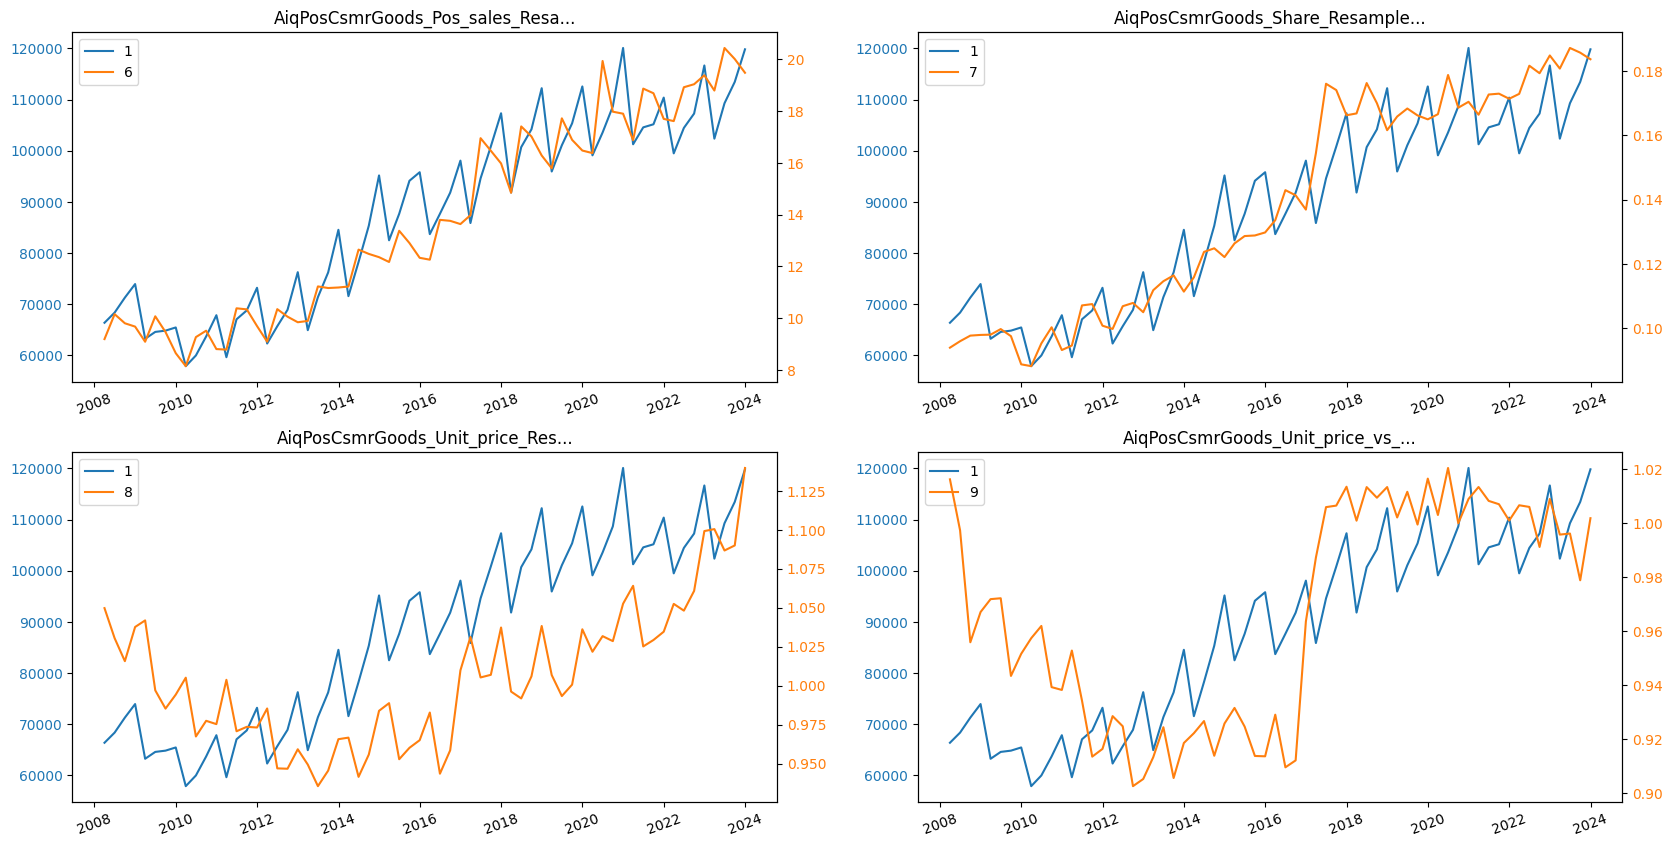

In [10]:
sdh.show_line_one_target(
    target=sample_target, #どの ticker のデータを描画するかを決めます
    y=funda_Q_ids[0], #y軸に表示するデータを variable_id で指定します
    X= alt_Q_ids, #x軸に表示するデータを variable_id の list で指定します（複数のグラフを一気に表示する時に list にします）
    col_num=2, #1行にいくつのグラフを表示するかを決めます
    vname_len_limit=30, #タイトルにXのvariable_id の変数名が表示されますが、表示を短くするために文字数を指定します
)

#### ベースとなる `variable` から変数を作成し、財務とマッチするのはどの変数か視覚的に確認できるようにします
- `sdh.transform` を使うことで様々な変数を作成し、どの変数が一番財務と関係性が強いのか一気に検証を行うことができます。
- `transform` の処理一覧は `data handler` のサンプル notebook を確認してください。

In [11]:
# resample_by をつかって、財務データの日付に従ってデータが aggregation されるように resample します。
alt_Q_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
alt_Q_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
alt_Q_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
alt_Q_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample_by(label=funda_Q_ids[0], func='mean').variable_ids

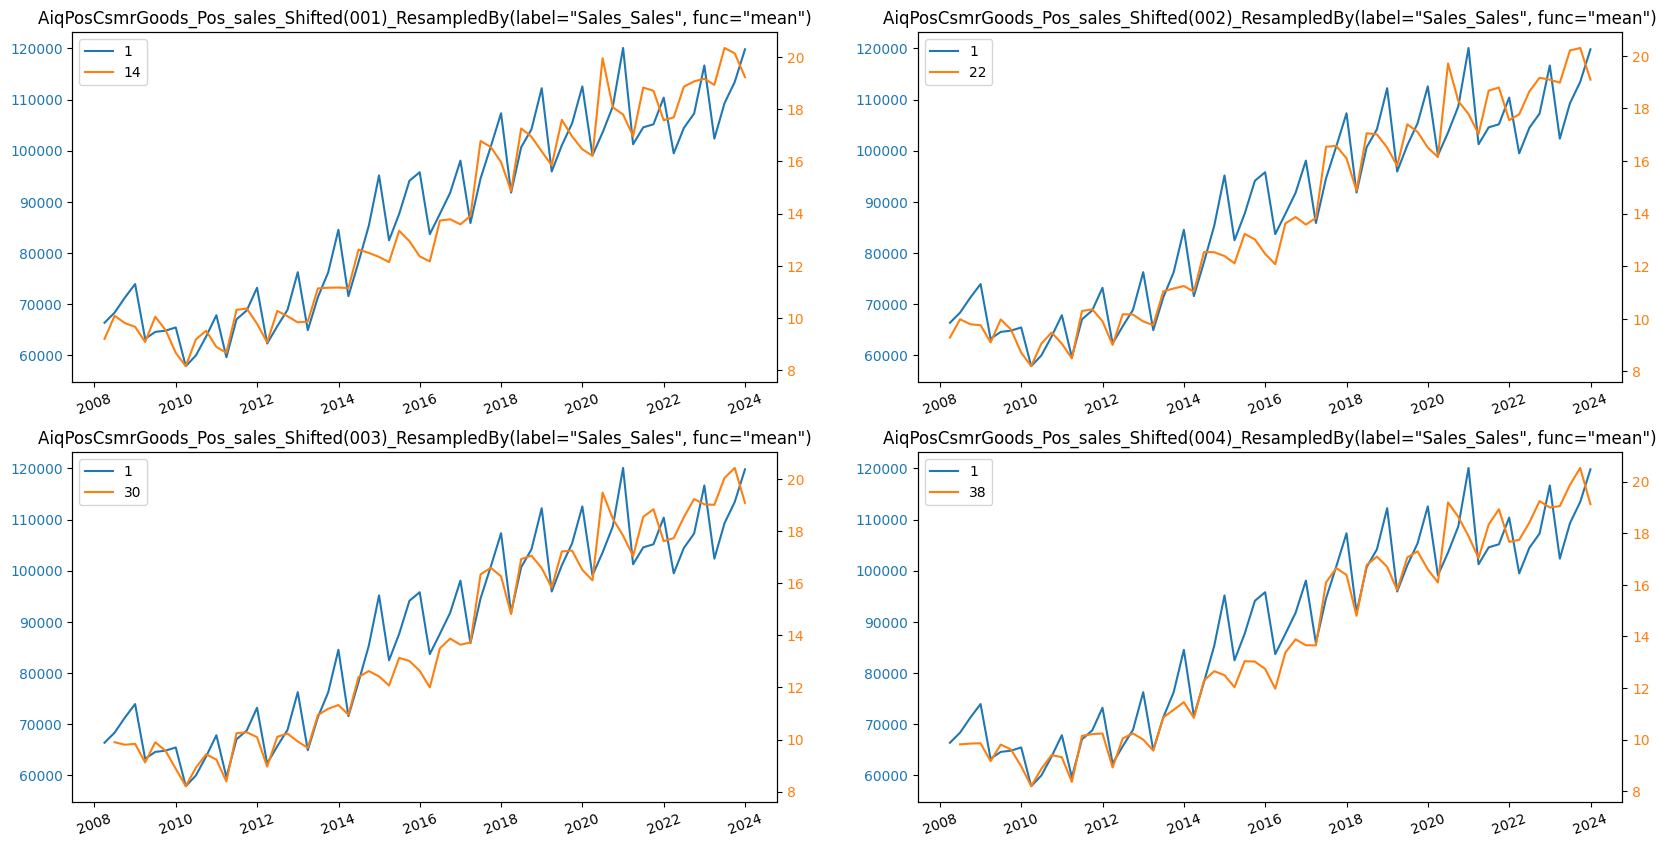

CPU times: user 48.2 s, sys: 2.57 s, total: 50.7 s
Wall time: 50.5 s


In [12]:
%%time

# View Sales vs Pos Sales
sdh.show_line_one_target(
    target=sample_target,
    y=funda_Q_ids[0],
    X=[alt_Q_shift_1_ids[0], alt_Q_shift_2_ids[0], 
       alt_Q_shift_3_ids[0], alt_Q_shift_4_ids[0]],
    col_num=2
)

### トレンドで相関が観測されてしまうケースもあるため、さらに一時差分をとった変数で確認します。

In [13]:
sales_id = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).diff(periods=1).variable_ids[-1]
alt_Q_shift_0_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_ids, periods=4).variable_ids
alt_Q_shift_1_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_1_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_2_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_2_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_3_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_3_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_4_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_4_ids, periods=4).diff(periods=1).variable_ids

# Check application of method chain.
sdh.transform.show_method_chain()

,data_id,variable_id,step_001,step_002,step_003,step_004
process_id,,,,,,
13,2,[43],-,-,log_diff(periods=4),diff(periods=1)
14,1,"[44, 45, 46, 47]",-,"resample_by(label=""Sales_Sales"", func=""mean"")",log_diff(periods=4),-
16,1,"[52, 53, 54, 55]",shift(periods=1),"resample_by(label=""Sales_Sales"", func=""mean"")",log_diff(periods=4),diff(periods=1)
18,1,"[60, 61, 62, 63]",shift(periods=2),"resample_by(label=""Sales_Sales"", func=""mean"")",log_diff(periods=4),diff(periods=1)
20,1,"[68, 69, 70, 71]",shift(periods=3),"resample_by(label=""Sales_Sales"", func=""mean"")",log_diff(periods=4),diff(periods=1)
22,1,"[76, 77, 78, 79]",shift(periods=4),"resample_by(label=""Sales_Sales"", func=""mean"")",log_diff(periods=4),diff(periods=1)


#### 相関計算を一つずつ実行します

In [14]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=0'] = ade.compu_rho(alt_Q_shift_0_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=1'] = ade.compu_rho(alt_Q_shift_1_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=2'] = ade.compu_rho(alt_Q_shift_2_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=3'] = ade.compu_rho(alt_Q_shift_3_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=4'] = ade.compu_rho(alt_Q_shift_4_logdiff_ids, sales_id, rename_features=features)
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

,n_shift=0,n_shift=1,n_shift=2,n_shift=3,n_shift=4
pos_sales,4.997442,12.097896,9.399373,6.841898,5.564104
share,0.938982,5.548166,4.808589,3.847833,4.132998
unit_price_vs_ind,0.403336,1.428821,1.148760,0.649208,0.351857
unit_price,-2.082218,-0.407680,-0.942549,-1.507292,-1.744150


In [15]:
# 結果は pooling しておいた DataFrame の中身から取得します
display(rho_pool.xs('rho', level=1).sort_values(rho_pool.columns[0], ascending=False))

,n_shift=0,n_shift=1,n_shift=2,n_shift=3,n_shift=4
pos_sales,0.044470,0.107435,0.083679,0.061344,0.049933
share,0.008363,0.049496,0.042920,0.034544,0.037111
unit_price_vs_ind,0.003593,0.012761,0.010262,0.005832,0.003162
unit_price,-0.018544,-0.003641,-0.008420,-0.013538,-0.015670


#### Ticker by Ticker で相関値を計算することもできます
- 以下では、上位5銘柄を選び出し関係性を描画します。

In [16]:
rho_time = ade.compu_rho(alt_Q_shift_1_logdiff_ids, sales_id, by='ticker', rename_features=features)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

,pos_sales,share,unit_price,unit_price_vs_ind
TICKER,,,,
2923-JP,6.993189,2.683322,2.103400,1.994910
2220-JP,6.554592,4.227241,0.088698,-0.312232
2221-JP,5.945839,3.286237,-0.676302,0.779556
4922-JP,5.915527,1.305480,2.841879,0.442815
4452-JP,5.774077,3.592139,4.481995,3.297125


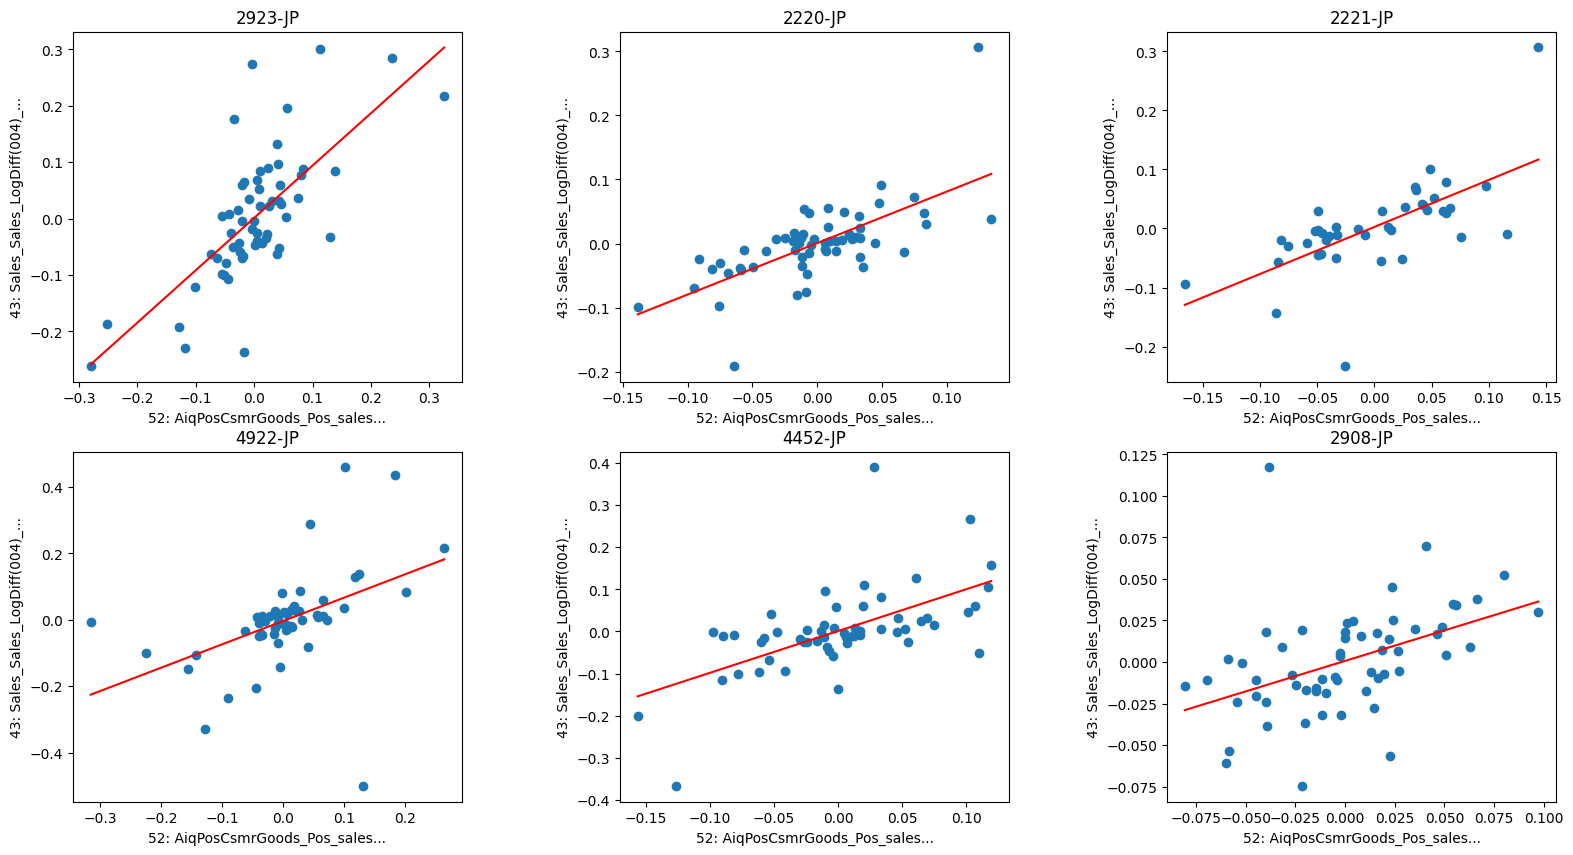

In [17]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=sales_id,
    x=alt_Q_shift_1_logdiff_ids[0],
    targets=top6tickers,
    col_num=3,
    vname_len_limit=25,
)

### Step3.2: 株価変化率との相関
- 財務と POS Csmr Goods の高い関連性が確認できたため、次は株価変化率との関連性を調べます
- 株価は POSデータに合わせるため、週次データに resample して比較していきます。

In [18]:
mkt_W_close_id = sdh.transform.resample(data_id=data_id_mkt, rule='W', fields='close', func='last').variable_ids[-1]
alt_W_ids = sdh.transform.resample(data_id=data_id_alt, rule='W', func='mean').variable_ids

#### 株価変化率とのプロット
財務データとの比較と同様に、描画してデータの形状を把握します

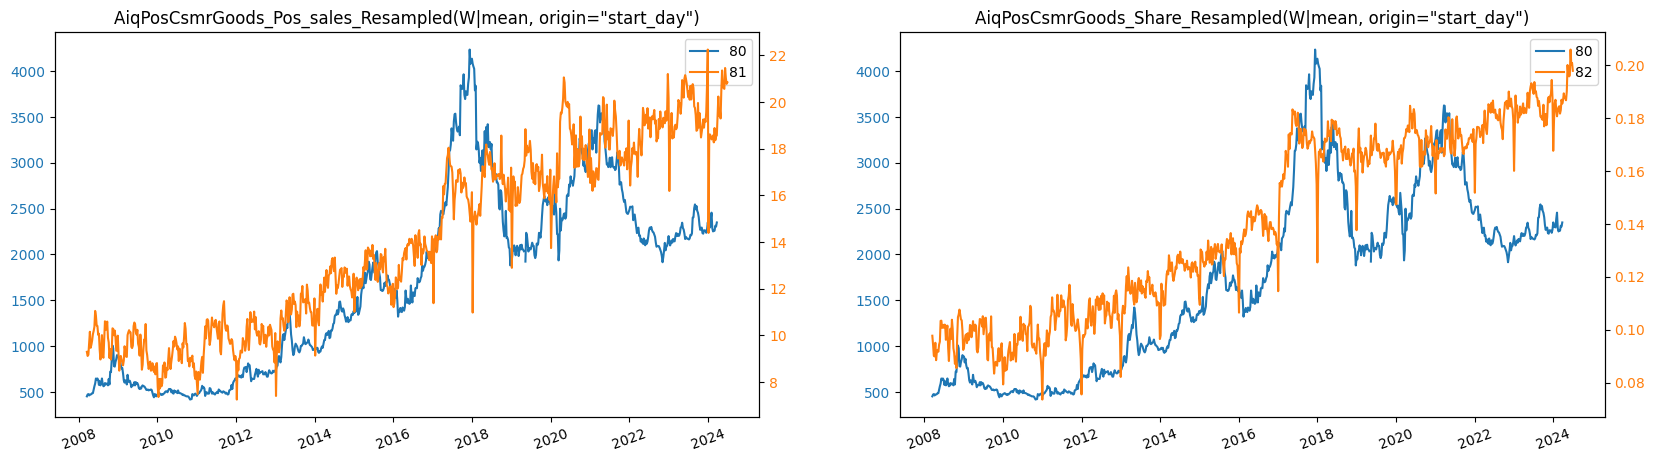

In [19]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_id,
    X=alt_W_ids[:2],
    col_num=2
)

### 最適な shift 幅の探索を財務データとの比較と同様に行っていきます

In [20]:
alt_W_shift_0_ids = sdh.transform.sma(fields=alt_W_ids, periods=12).variable_ids
alt_W_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_5_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_6_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_7_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_8_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample(rule='W', func='mean').sma(periods=12).variable_ids

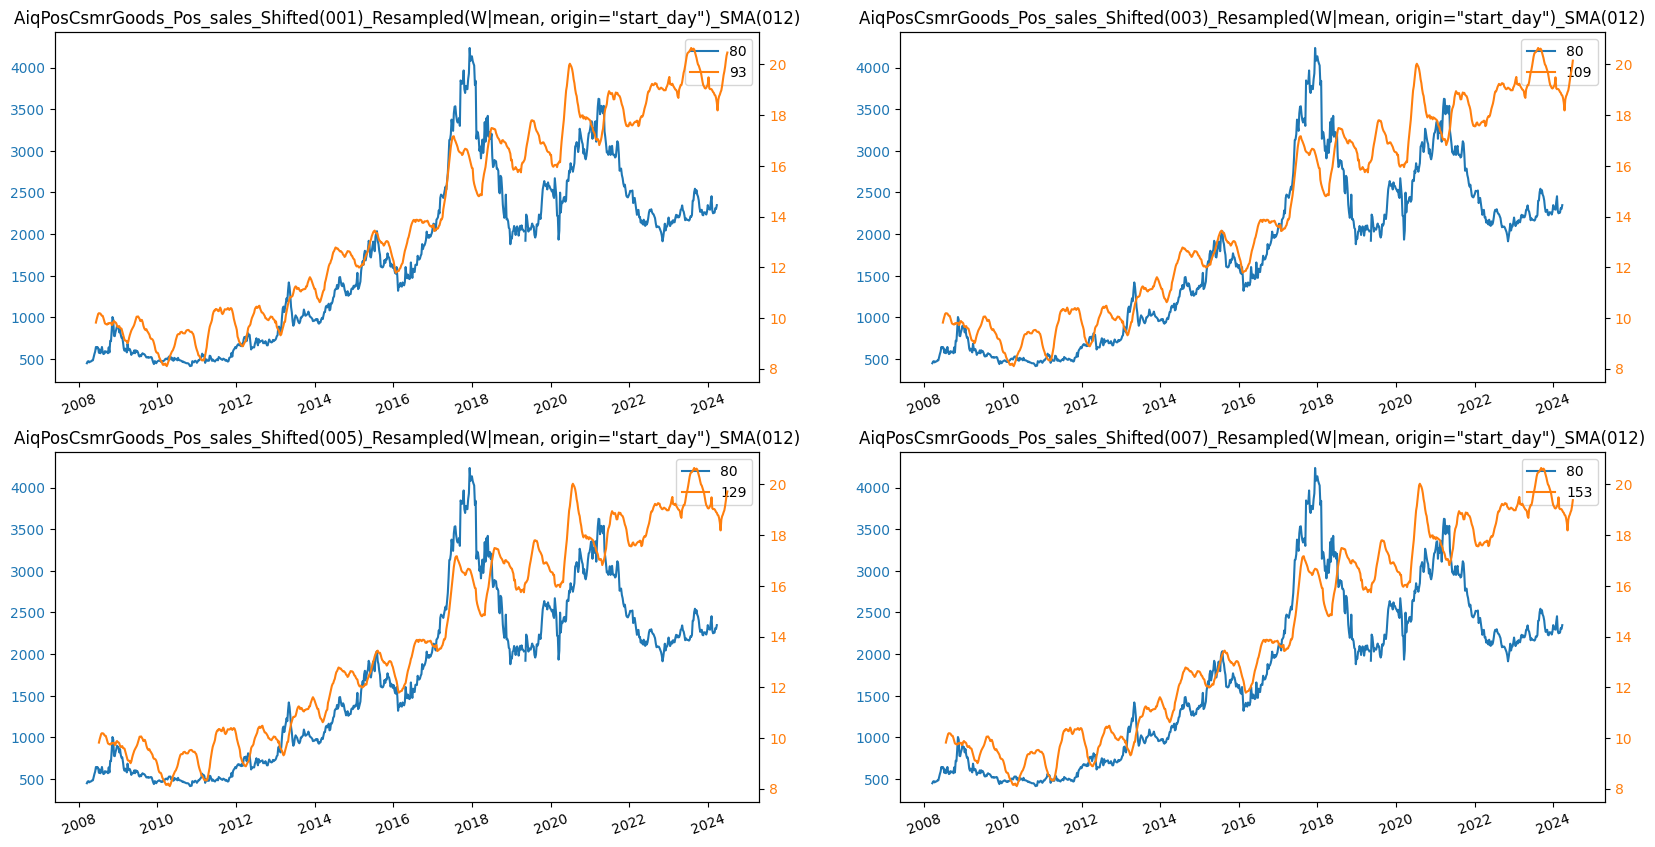

In [21]:
# View Sales vs Pos Sales
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_id,
    X=[alt_W_shift_1_ids[0], alt_W_shift_3_ids[0], 
       alt_W_shift_5_ids[0], alt_W_shift_7_ids[0]],
    col_num=2
)

> 前年同週比を計算してから相関の計算をします

In [22]:
alt_W_shift_0_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_0_ids, periods=52).variable_ids
alt_W_shift_1_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_1_ids, periods=52).variable_ids
alt_W_shift_2_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_2_ids, periods=52).variable_ids
alt_W_shift_3_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_3_ids, periods=52).variable_ids
alt_W_shift_4_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_4_ids, periods=52).variable_ids
alt_W_shift_5_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_5_ids, periods=52).variable_ids
alt_W_shift_6_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_6_ids, periods=52).variable_ids
alt_W_shift_7_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_7_ids, periods=52).variable_ids
alt_W_shift_8_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_8_ids, periods=52).variable_ids

close_ret = sdh.transform.dropna(fields=mkt_W_close_id, how='all').log_diff(periods=1, names='ret').variable_ids[-1]

funda_Q_ids# メソッドチェーンを確認
sdh.transform.show_method_chain()

,data_id,variable_id,step_001,step_002,step_003,step_004
process_id,,,,,,
13,2,[43],-,-,log_diff(periods=4),diff(periods=1)
14,1,"[44, 45, 46, 47]",-,"resample_by(label=""Sales_Sales"", func=""mean"")",log_diff(periods=4),-
16,1,"[52, 53, 54, 55]",shift(periods=1),"resample_by(label=""Sales_Sales"", func=""mean"")",log_diff(periods=4),diff(periods=1)
18,1,"[60, 61, 62, 63]",shift(periods=2),"resample_by(label=""Sales_Sales"", func=""mean"")",log_diff(periods=4),diff(periods=1)
20,1,"[68, 69, 70, 71]",shift(periods=3),"resample_by(label=""Sales_Sales"", func=""mean"")",log_diff(periods=4),diff(periods=1)
22,1,"[76, 77, 78, 79]",shift(periods=4),"resample_by(label=""Sales_Sales"", func=""mean"")",log_diff(periods=4),diff(periods=1)
46,1,"[169, 170, 171, 172]",-,"resample(rule=""W"", func=""mean"", origin=""start_day"")",sma(periods=12),log_diff(periods=52)
47,1,"[173, 174, 175, 176]",shift(periods=1),"resample(rule=""W"", func=""mean"", origin=""start_day"")",sma(periods=12),log_diff(periods=52)
48,1,"[177, 178, 179, 180]",shift(periods=2),"resample(rule=""W"", func=""mean"", origin=""start_day"")",sma(periods=12),log_diff(periods=52)


> 相関係数とそのT値を計算します

In [23]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=0, sma=12'] = ade.compu_rho(alt_W_shift_0_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=1, sma=12'] = ade.compu_rho(alt_W_shift_1_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=2, sma=12'] = ade.compu_rho(alt_W_shift_2_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=3, sma=12'] = ade.compu_rho(alt_W_shift_3_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=4, sma=12'] = ade.compu_rho(alt_W_shift_4_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=5, sma=12'] = ade.compu_rho(alt_W_shift_5_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=6, sma=12'] = ade.compu_rho(alt_W_shift_6_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=7, sma=12'] = ade.compu_rho(alt_W_shift_7_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=8, sma=12'] = ade.compu_rho(alt_W_shift_8_sma12_logdiff_ids, close_ret, rename_features=features)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

,"n_shift=0, sma=12","n_shift=1, sma=12","n_shift=2, sma=12","n_shift=3, sma=12","n_shift=4, sma=12","n_shift=5, sma=12","n_shift=6, sma=12","n_shift=7, sma=12","n_shift=8, sma=12"
pos_sales,6.279219,6.329904,6.122805,6.330841,6.412351,6.155679,5.711314,5.654076,5.224711
share,3.880371,3.783688,3.590032,3.387258,3.570240,3.423882,3.231025,3.270467,3.012966
unit_price,1.419408,1.452857,1.693640,1.937371,1.931253,2.055658,1.883475,1.679174,1.383341
unit_price_vs_ind,-0.506442,-0.790555,-0.728134,-0.502856,-0.576885,-0.565365,-0.922102,-1.011972,-1.231649


> もっとも相関の良いN件のTickerを選んで散布図で関係性を視覚的に確認します

In [24]:
rho_time = ade.compu_rho(alt_W_shift_1_sma12_logdiff_ids, close_ret, by='ticker', rename_features=features)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

,pos_sales,share,unit_price,unit_price_vs_ind
TICKER,,,,
2212-JP,3.365803,1.561853,1.106176,0.123451
2281-JP,3.294872,3.096813,2.156616,1.056039
5194-JP,3.287898,3.499298,2.009418,1.413868
2884-JP,2.809722,0.568511,0.030143,1.485993
2816-JP,2.698971,0.615577,0.627799,1.448912


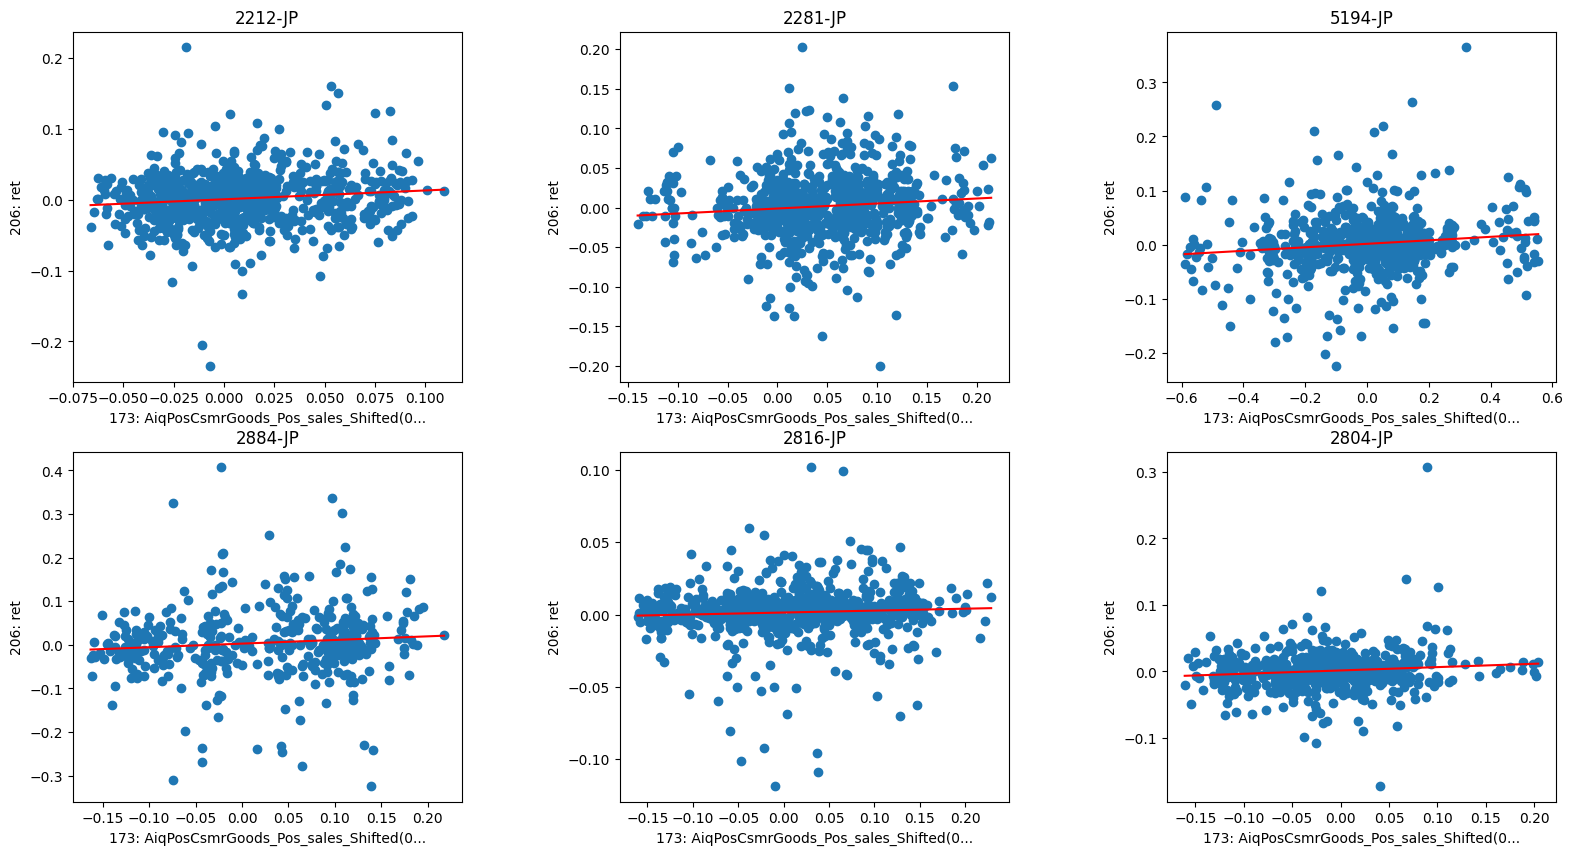

In [25]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=close_ret,
    x=alt_W_shift_1_sma12_logdiff_ids[0],
    targets=top6tickers,
    col_num=3,
    vname_len_limit=35,
)

# Step4: Quantile Backtest
- Step3で作成した変数をベースに、様々なファクターを作成して計算を行っていきます。
- ここでは12週移動平均をとった `pos_sales` の変数をファクター値に選んでいます。
- 実務では移動平均値やシフト幅などのハイパーパラメータを変動させることで、バックテストの結果が大きく影響を受けないことを確認します。

In [26]:
# 3分位ポートフォリオを組みます
nq = 3

# 片道の取引コストを想定します
exe_cost = 0.0005

# Step3 で計算しておいた variable_id を取得します
pos_sales = alt_W_shift_1_sma12_logdiff_ids[0]
ret = close_ret

In [27]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pos_sales,
    ret,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,0.554052,0.036756,0.141967,0.258901,0.575130,2.720879,-0.494842,0.074277
#2,0.750725,0.049803,0.134303,0.370824,0.573834,5.114418,-0.392160,0.126996
#3,1.349491,0.089525,0.139376,0.642326,0.593264,2.665337,-0.424414,0.210937
#3-#1,0.795439,0.052769,0.048962,1.077763,0.585492,5.386216,-0.049287,1.070657
#3-#1(cost),0.755617,0.050127,0.048964,1.023753,0.580311,5.386216,-0.050009,1.002371
